# CSCI4022 Final Project; Colorado Avalanches


***

- I am using data for avalanches in Vail and Summit County from the Colorado Avalanche Information Center. The CAIC website allowed me to compile a report of all Avalanches recorded in Colorado from October 2010 to April 2021. My data includes information on the start elevation of the avalanche and the average width of the avalanche. So far, I have clustered the data based on start elevation and average width. The data looks to be clustering with a heavy influence on the start elevation of the avalanches. I want to normalize my data and cluster on normalized data to achieve better clusters. By looking at the history of avalanches that have occurred, I will find the elevation range I could expect to see different sized avalanches triggered. 
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Read in historic avalanche data from CAIC file
avalanche = pd.read_csv("CAIC_avalanches.csv", encoding = 'UTF-8', skip_blank_lines = False)

#Get the names of the columns to aid in manipulation
colnames = list(avalanche.columns)
print(colnames)

#clean the data to discard unneeded information and records missing important information
avalanche.index = avalanche['Obs ID']
avalanche = avalanche.drop(columns = ['Obs ID', 'Date Known', 'Time', 'Time Known', 'HW Zone', 'Operation', 'First Name', 'Last Name', 'HW Path', '#', 'Trigger', 'Trigger_sub', 'Comments', 'Sliding Sfc', 'Avg Vertical', 'Max Vertical', 'Vertical units', 'Avg Crown Height', 'Max Crown Height', 'Crown Height units', 'Terminus '])
avalanche = avalanche.dropna(subset = ['Rsize', 'Type', 'Start Zone Elev', 'Avg Width'])

#the highest start zone elevation in the data set is 39,990ft which would be an error
#since the tallest peak in Colorado is 14,439ft
avalanche = avalanche.drop(avalanche['Start Zone Elev'].idxmax())

#print some data so we can see what we are working with
avalanche.head()

['Obs ID', 'Date', 'Date Known', 'Time', 'Time Known', 'BC Zone', 'HW Zone', 'Operation', 'Landmark', 'First Name', 'Last Name', 'HW Path', '#', 'Elev', 'Asp', 'Type', 'Trigger', 'Trigger_sub', 'Rsize', 'Dsize', 'Incident', 'Area Description', 'Comments', 'Avg Slope Angle', 'Start Zone Elev', 'Start Zone Elev units', 'Sliding Sfc', 'Weak Layer', 'Weak Layer Type', 'Avg Width', 'Max Width', 'Width units', 'Avg Vertical', 'Max Vertical', 'Vertical units', 'Avg Crown Height', 'Max Crown Height', 'Crown Height units', 'Terminus ']


,Date,BC Zone,Landmark,Elev,Asp,Type,Rsize,Dsize,Incident,Area Description,Avg Slope Angle,Start Zone Elev,Start Zone Elev units,Weak Layer,Weak Layer Type,Avg Width,Max Width,Width units
Obs ID,,,,,,,,,,,,,,,,,,
66783,2021/04/23,Vail & Summit County,buffalo Mountain,>TL,N,SS,R1,D1.5,NaN,Maximum Elvis,NaN,12400.0,ft,NaN,NaN,50.0,NaN,ft
66780,2021/04/23,Front Range,Herman Gulch,>TL,S,SS,R1,D1.5,NaN,Woods Mountain,NaN,12800.0,ft,NaN,NaN,100.0,NaN,ft
66738,2021/04/20,Vail & Summit County,10-mile Range,>TL,SW,SS,R1,D1.5,NaN,Pacific Peak,38.0,13300.0,ft,Layer,Faceted Crystals,100.0,NaN,ft
66538,2021/04/05,Northern San Juan,NaN,<TL,NE,WS,R1,D2,NaN,NaN,45.0,10800.0,ft,NaN,NaN,40.0,NaN,ft
66504,2021/04/04,Northern San Juan,NaN,<TL,W,WS,R2,D2,NaN,C-H,35.0,10800.0,ft,NaN,NaN,80.0,120.0,ft


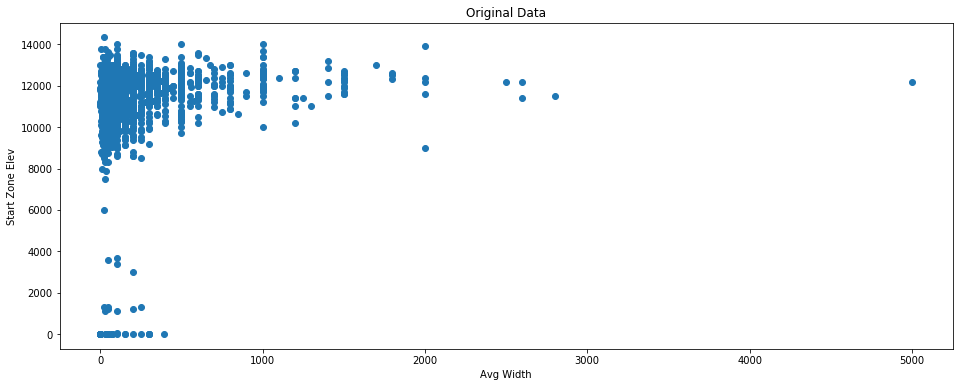

In [2]:
#Plot the Start Zone Elevation against Average width to see where different sized avalanches occur
fig, ax= plt.subplots(figsize=(16,6))
plt.scatter(avalanche['Avg Width'], avalanche['Start Zone Elev'])
ax.set_xlabel('Avg Width')
ax.set_ylabel('Start Zone Elev')
ax.set_title('Original Data')
plt.show()

In [3]:
avalanche.describe()

,Avg Slope Angle,Start Zone Elev,Avg Width,Max Width
count,1495.000000,2451.000000,2451.000000,1404.000000
mean,34.843478,11321.529988,178.168862,185.934473
std,8.184346,1977.616899,282.604478,260.015261
min,0.000000,0.000000,0.000000,0.000000
25%,34.000000,11000.000000,40.000000,50.000000
50%,35.000000,11800.000000,100.000000,100.000000
75%,39.000000,12200.000000,200.000000,200.000000
max,65.000000,14336.000000,5000.000000,3000.000000


In [10]:
def dist(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

#clean out other unneeded columns
aval_elev_vs_size = avalanche.drop(columns = ['Avg Slope Angle', 'Date', 'BC Zone', 'Landmark', 'Elev', 'Asp', 'Type', 'Rsize', 'Dsize', 'Incident', 'Area Description', 'Avg Slope Angle', 'Start Zone Elev units', 'Weak Layer', 'Weak Layer Type', 'Width units', 'Max Width'])

#cluster into 5 clusters to get more distinction between groups
K = 5
clocs=np.random.choice(range(len(aval_elev_vs_size)), size=K)
np.array(aval_elev_vs_size.iloc[clocs[0]])

#set initial centroids
centroids = np.array([aval_elev_vs_size.iloc[clocs[0]], aval_elev_vs_size.iloc[clocs[1]], aval_elev_vs_size.iloc[clocs[2]], aval_elev_vs_size.iloc[clocs[3]], aval_elev_vs_size.iloc[clocs[4]]]) # initialize
dists = [0]*K
clusters = np.array([-1]*len(aval_elev_vs_size))
for i in range(50): #50 steps is fine; or a tolerance/change check.
    #update classifications
    for j in range(len(aval_elev_vs_size)):
        dists = [dist(aval_elev_vs_size.iloc[j], cent) for cent in centroids]
        assignment = dists.index(min(dists))
        clusters[j] = assignment
    #update centroids
    for j in range(K):
        centroids[j]=[np.sum(aval_elev_vs_size.iloc[clusters==j,0])/len(aval_elev_vs_size.iloc[clusters==j,0]),\
                      np.sum(aval_elev_vs_size.iloc[clusters==j,1])/len(aval_elev_vs_size.iloc[clusters==j,1])]

[3 3 3 ... 1 0 1]


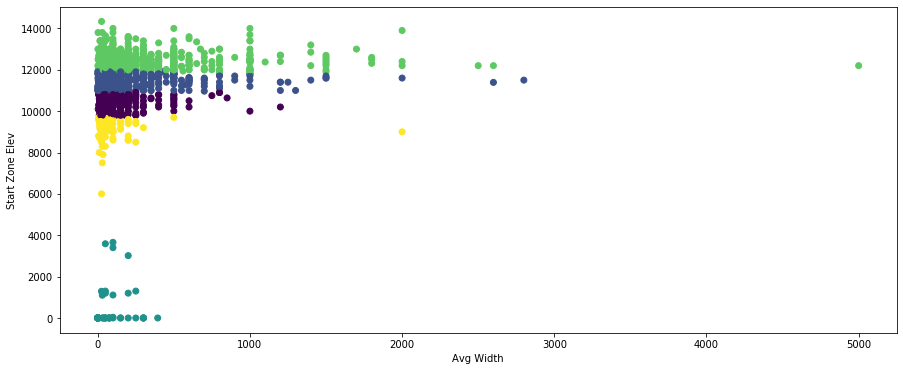

In [11]:
fig, ax = plt.subplots(figsize=(15,6))
print(clusters)
plt.scatter(aval_elev_vs_size['Avg Width'], aval_elev_vs_size['Start Zone Elev'], c=clusters)
ax.set_xlabel('Avg Width')
ax.set_ylabel('Start Zone Elev')
plt.show()

The standard deviation on the start zone elevation is way higher than average width of the avalanche. The data clusters look like they are being heavily influenced by the start zone elevation. I need to normalize my data before clustering to see if I can get better clusters. 